In [1]:
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
from sklearn import metrics # for the evaluation
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import tensorflow as tf
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
import math
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout

import matplotlib.pyplot as plt

###### predict date range ######
# pd.date_range(start="2021-12-26",end="2022-01-01")
# pd.date_range(start="2022-01-23",end="2022-01-29")

In [2]:
def multivariate_data(dataset, target, start_index, end_index, history_size, target_size, step, single_step=False):
    data = []
    labels = []
    
    start_index = start_index + history_size
    if end_index is None:
        end_index = len(dataset) - target_size
    
    for i in range(start_index, end_index):
        indices = range(i-history_size, i, step)
        data.append(dataset[indices])
        
        if single_step:
            labels.append(target[i+target_size])
        else:
            labels.append(target[i:i+target_size])
    
    return np.array(data), np.array(labels)
  
def multi_step_plot(history, true_future, prediction):
    plt.figure(figsize=(12,6))
    num_in = create_time_steps(len(history))
    num_out = len(true_future)
    
    plt.plot(num_in, np.array(history[:,1]), label='History')
    plt.plot(np.arange(num_out)/STEP, np.array(true_future),'bo', label='True Future')
    
    if prediction.any():
        plt.plot(np.arange(num_out)/STEP, np.array(prediction), 'ro', label='Predicted Future')
    plt.legend(loc='upper left')
    plt.show()

In [3]:
# f1 = pd.concat([pd.read_csv('../Data/ground_temp_train.csv'), pd.read_csv('../Data/ground_temp_test.csv')])
# f2 = pd.concat([pd.read_csv('../Data/sunrise_sunset_train.csv'), pd.read_csv('../Data/sunrise_sunset_test.csv')])

# f1['년도'] = pd.to_datetime(f1['일시']).apply(lambda x: x.year)
# f1['월'] = pd.to_datetime(f1['일시']).apply(lambda x: x.month)
# f1['일'] = pd.to_datetime(f1['일시']).apply(lambda x: x.day)
# f1['시'] = pd.to_datetime(f1['일시']).apply(lambda x: x.hour)

# f1.drop(columns=['일시'],inplace=True)

# f2['Unnamed: 0'] = f2['Unnamed: 0'].apply(lambda x: datetime.strptime(str(x), '%Y%m%d'))
# f2['년도'] = pd.to_datetime(f2['Unnamed: 0']).apply(lambda x: x.year)
# f2['월'] = pd.to_datetime(f2['Unnamed: 0']).apply(lambda x: x.month)
# f2['일'] = pd.to_datetime(f2['Unnamed: 0']).apply(lambda x: x.day)

# f2.drop(columns=['Unnamed: 0'],inplace=True)

In [4]:
test_idx = 129448
valid_idx = 89936

df = pd.read_csv('../Data/smart_farm_final_scaled.csv')
df['열공급량(kWh'] = df['열공급량(kWh)'].fillna(0)
# df['열공급량(kWh)'] = df['열공급량(kWh)'] * 1000

# df.iloc[:test_idx].groupby('년월일')['열공급량(kWh)'].sum().plot()
df.head()

,년도,월,일사량(W/㎡),외기온(℃),외기습도(%),풍속(m/s),풍향(º),내부 온도,내부 습도,차광스크린(수평),차열스크린(수평),에너지스크린(수평),에너지스크린(수직),배기팬,천창,유동팬,팬코일 B동,환기온도(천창 제어온도),난방온도(설정온도),누적강수량,현지기압,해면기압,일조,PM10_1시간,PM25_1시간,오존_1시간,이산화질소_1시간,일산화탄소_1시간,아황산가스_1시간,차광스크린_개방,일출시간,일몰시간,일출3시간후,일출1시간후,일몰3시간후,일몰1시간반전,하루길이,지면온도,차광스크린_개방조절_0%~30%개방,차광스크린_개방조절_100%개방,차광스크린_개방조절_30%~80%개방,차광스크린_개방조절_80%~100%개방,차열스크린_온도조절_23도~25도,차열스크린_온도조절_23도미만,차열스크린_온도조절_25도~26도,차열스크린_온도조절_26도이상,차열스크린_개방조절_0%~30%개방,차열스크린_개방조절_100%개방,차열스크린_개방조절_30%~70%개방,차열스크린_개방조절_70%~100%개방,시간범주_그외,시간범주_야간,시간범주_주간,일몰전후_일몰1시간반_전,일몰전후_일몰1시간반_후,일출일몰_일몰,일출일몰_일출,오존등급_보통,오존등급_좋음,아황산가스등급_보통,아황산가스등급_좋음,이산화질소등급_나쁨,이산화질소등급_보통,이산화질소등급_좋음,PM10등급_나쁨,PM10등급_보통,PM10등급_좋음,PM25등급_나쁨,PM25등급_보통,PM25등급_좋음,일_1,일_2,일_3,일_4,일_5,일_6,일_7,일_8,일_9,일_10,일_11,일_12,일_13,일_14,일_15,일_16,일_17,일_18,일_19,일_20,일_21,일_22,일_23,일_24,일_25,일_26,일_27,일_28,일_29,일_30,일_31,시_0,시_1,시_2,시_3,시_4,시_5,시_6,시_7,시_8,시_9,시_10,시_11,시_12,시_13,시_14,시_15,시_16,시_17,시_18,시_19,시_20,시_21,시_22,시_23,열공급량(kWh),열공급량(kWh
0,0.0,0.909091,0.0,0.495238,0.643678,0.000000,0.901408,0.359322,0.485804,0.0,0.0,0.0,0.0,0,0.0,1,0.0,0.333333,0.5,0.0,0.506494,0.506452,0.757607,0.264957,0.283784,0.02381,0.320513,0.142857,0.04,0,0.771429,0.016129,0.771429,0.771429,0.016129,0.012195,0.219231,0.254545,1,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,1,1,0,0,1,0,1,0,0,1,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.9,0.9
1,0.0,0.909091,0.0,0.495238,0.643678,0.024242,0.954930,0.352542,0.507886,0.0,0.0,0.0,0.0,0,0.0,1,0.0,0.333333,0.5,0.0,0.506494,0.506452,0.000000,0.264957,0.283784,0.02381,0.320513,0.142857,0.04,0,0.771429,0.016129,0.771429,0.771429,0.016129,0.012195,0.219231,0.254545,1,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,1,1,0,0,1,0,1,0,0,1,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.9,0.9
2,0.0,0.909091,0.0,0.492063,0.643678,0.054545,0.281690,0.338983,0.536278,0.0,0.0,0.0,0.0,0,0.0,1,1.0,0.333333,0.5,0.0,0.503247,0.503226,0.000000,0.264957,0.283784,0.02381,0.320513,0.142857,0.04,0,0.771429,0.016129,0.771429,0.771429,0.016129,0.012195,0.219231,0.254545,1,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,1,1,0,0,1,0,1,0,0,1,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.9,0.9
3,0.0,0.909091,0.0,0.492063,0.643678,0.078788,0.332394,0.338983,0.515773,0.0,0.0,0.0,0.0,0,0.0,1,1.0,0.333333,0.5,0.0,0.503247,0.503226,0.000000,0.264957,0.283784,0.02381,0.320513,0.142857,0.04,0,0.771429,0.016129,0.771429,0.771429,0.016129,0.012195,0.219231,0.254545,1,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,1,1,0,0,1,0,1,0,0,1,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.8,0.8
4,0.0,0.909091,0.0,0.492063,0.643678,0.054545,0.332394,0.335593,0.528391,0.0,0.0,0.0,0.0,0,0.0,1,1.0,0.333333,0.5,0.0,0.503247,0.503226,0.000000,0.264957,0.283784,0.02381,0.320513,0.142857,0.04,0,0.771429,0.016129,0.771429,0.771429,0.016129,0.012195,0.219231,0.254545,1,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,1,1,0,0,1,0,1,0,0,1,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1.0,1.0


In [5]:

# # f1 merge
# df = pd.merge(df,f1, on=['년도','월','일','시'], how='left')
# # f2 merge
# df = pd.merge(df,f2, on=['년도','월','일'], how='left')

# df.set_index('시간',inplace=True)
# df.drop(columns=['년월일', '년도', '월', '일', '시', '분'],inplace=True)
print("total data: ",df.shape)

print("train data: ",df.iloc[:test_idx].shape)
print("test data: ",df.iloc[test_idx:].shape)

total data:  (148168, 127)
train data:  (129448, 127)
test data:  (18720, 127)


In [6]:
# dummy_lst = ['차광스크린_광도조절','차광스크린_개방조절', '차열스크린_온도조절', '차열스크린_광도조절', '차열스크린_개방조절', '시간범주', '일몰전후', '일출일몰', '오존등급', '아황산가스등급', '이산화질소등급', 'PM10등급', 'PM25등급', '배기팬',
#              '유동팬','팬코일 B동', '환기온도(천창 제어온도)', '차광스크린_개방']

# X_dummy = pd.get_dummies(df[dummy_lst])
# print("dummy x data shape:",X_dummy.shape)

In [7]:
# dummy_lst.append('열공급량(kWh)')

# X_scaler = MinMaxScaler()
# Y_scaler = MinMaxScaler()

# X_train_data = X_scaler.fit_transform(df.iloc[:test_idx,~df.columns.isin(dummy_lst)]) 
# Y_train_data = Y_scaler.fit_transform(df.iloc[:test_idx][['열공급량(kWh)']])
# print("train x data shape:",X_train_data.shape)

# X_test_data = X_scaler.transform(df.iloc[test_idx-31:,~df.columns.isin(dummy_lst)])
# Y_test_data = Y_scaler.transform(df.iloc[test_idx-31:][['열공급량(kWh)']])
# print("test x data shape:",X_test_data.shape)

# X_data = df.iloc[:,~df.columns.isin(dummy_lst)]
# X_train_data = np.log1p(np.array(X_data.iloc[:test_idx,~X_data.columns.isin(['열공급량(kWh'])]))
# Y_train_data = np.log1p(np.array(X_data.iloc[:test_idx][['열공급량(kWh']]))
# X_test_data = np.log1p(np.array(X_data.iloc[test_idx-31:,~X_data.columns.isin(['열공급량(kWh'])]))
# Y_test_data = np.log1p(np.array(X_data.iloc[test_idx-31:][['열공급량(kWh']]))


In [8]:
# X_dummy_train = np.array(X_dummy.iloc[:test_idx])
# print("dummy train x data shape:",X_dummy_train.shape)
# X_train_data = np.concatenate((X_train_data, X_dummy_train),axis=1)
# print("train x data shape:",X_train_data.shape)

# X_dummy_test = np.array(X_dummy.iloc[test_idx-31:])
# print("dummy test x data shape:",X_dummy_test.shape)
# X_test_data = np.concatenate((X_test_data, X_dummy_test),axis=1)
# print("test x data shape:",X_test_data.shape)

In [9]:
# print("before train x data shape:",X_train_data.shape)
# print("before train y data shape:",Y_train_data.shape)

In [10]:
# print("before test x data shape:",X_test_data.shape)
# print("before test y data shape:",Y_test_data.shape)

In [26]:
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [20]:
# As we are doing multiple-step forecasting, let’s allow the model to see past 48 hours of data and forecast the 10 hrs after data
# hist_window = 48 / horizon = 10

# row : min -> 분단위 예측~
# past_history=360
# future_target = len(df.iloc[test_idx])
# STEP = 30
# x_train, y_train = custom_ts_multi_data_prep(df.iloc[:,~df.columns.isin(['열공급량(kWh'])].values)), df.iloc[:,df.columns.isin(['열공급량(kWh'])].values)), 0, valid_idx, hist_window, horizon)
# x_vali, y_vali = custom_ts_multi_data_prep(df.iloc[:,~df.columns.isin(['열공급량(kWh'])].values)), df.iloc[:,df.columns.isin(['열공급량(kWh'])].values)), valid_idx, test_idx, hist_window, horizon)
# x_test, y_test = custom_ts_multi_data_prep(df.iloc[:,~df.columns.isin(['열공급량(kWh'])].values)), df.iloc[:,df.columns.isin(['열공급량(kWh'])].values)), test_idx-31, None, hist_window, horizon)

# future_target = 72
# x_train_multi, y_train_multi = multivariate_data(df.iloc[:,~df.columns.isin(['열공급량(kWh'])].values, df.iloc[:,df.columns.isin(['열공급량(kWh'])].values, 0,
#                                                 valid_idx, past_history,
#                                                 future_target, STEP)
# x_val_multi, y_val_multi = multivariate_data(df.iloc[:,~df.columns.isin(['열공급량(kWh'])].values, df.iloc[:,df.columns.isin(['열공급량(kWh'])].values,
#                                             valid_idx, None, past_history,
#                                             future_target, STEP)

past_history = 720 #지난 5일동안 수집된 데이터
future_target = 72 #12시간 앞선값을 예측
STEP = 6 #한시간 간격으로 샘플링

x_train_single, y_train_single = multivariate_data(df.iloc[:,~df.columns.isin(['열공급량(kWh'])].values, df.iloc[:,df.columns.isin(['열공급량(kWh'])].values, 
                                                   0, valid_idx, past_history, future_target, STEP, single_step=True)
x_val_single, y_val_single = multivariate_data(df.iloc[:,~df.columns.isin(['열공급량(kWh'])].values, df.iloc[:,df.columns.isin(['열공급량(kWh'])].values, 
                                                   valid_idx, None, past_history, future_target, STEP, single_step=True)

In [21]:
print('Single window of past history: {}'. format(x_train_single.shape))
print('\n Target temperature to predict : {}'.format(y_train_single.shape))

Single window of past history: (89216, 120, 126)

 Target temperature to predict : (89216, 1)


In [22]:
print("transformed validation x data shape:",x_val_single.shape) # (data length, hist_window, n_features)
print("transformed validation y data shape:",y_val_single.shape) # (data length, horizon, n_features)

transformed validation x data shape: (57440, 120, 126)
transformed validation y data shape: (57440, 1)


In [21]:
# print("transformed test x data shape:",x_test.shape) # (data length, hist_window, n_features)

In [27]:
BATCH_SIZE = 64
BUFFER_SIZE = 10
train_data_single = tf.data.Dataset.from_tensor_slices((x_train_single, y_train_single))
train_data_single = train_data_single.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_data_single = tf.data.Dataset.from_tensor_slices((x_val_single, y_val_single))
val_data_single = val_data_single.batch(BATCH_SIZE).repeat()

InternalError: Failed copying input tensor from /job:localhost/replica:0/task:0/device:CPU:0 to /job:localhost/replica:0/task:0/device:GPU:0 in order to run _EagerConst: Dst tensor is not initialized.

In [24]:
lstm_model = tf.keras.models.Sequential([
    LSTM(200, return_sequences=True, input_shape=x_train_single.shape[-2:]),
    LSTM(200),
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(units=STEP),
])
lstm_model.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.005), loss=tf.keras.metrics.mean_squared_error, metrics=[tf.keras.metrics.RootMeanSquaredError(name='rmse')])
lstm_model.summary() 

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 120, 200)          261600    
                                                                 
 lstm_3 (LSTM)               (None, 200)               320800    
                                                                 
 dense_2 (Dense)             (None, 128)               25728     
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_3 (Dense)             (None, 6)                 774       
                                                                 
Total params: 608,902
Trainable params: 608,902
Non-trainable params: 0
_________________________________________________________________


In [18]:
model_path = 'LSTM_Multivariate_real.h5'
early_stopings = tf.keras.callbacks.EarlyStopping(monitor='val_rmse', min_delta=0, patience=15, verbose=1, mode='min')
checkpoint =  tf.keras.callbacks.ModelCheckpoint(model_path, monitor='val_rmse', save_best_only=True, mode='min', verbose=0)
callbacks=[early_stopings,checkpoint]
history = lstm_model.fit(x_train_multi, y_train_multi,epochs=100,steps_per_epoch=50,validation_data=(x_val_multi,y_val_multi),validation_steps=20,verbose=1,callbacks=callbacks, shuffle=False)

Epoch 1/100


ValueError: in user code:

    File "/Users/hongjiwon/miniforge3/envs/tf/lib/python3.8/site-packages/keras/engine/training.py", line 878, in train_function  *
        return step_function(self, iterator)
    File "/Users/hongjiwon/miniforge3/envs/tf/lib/python3.8/site-packages/keras/engine/training.py", line 867, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Users/hongjiwon/miniforge3/envs/tf/lib/python3.8/site-packages/keras/engine/training.py", line 860, in run_step  **
        outputs = model.train_step(data)
    File "/Users/hongjiwon/miniforge3/envs/tf/lib/python3.8/site-packages/keras/engine/training.py", line 809, in train_step
        loss = self.compiled_loss(
    File "/Users/hongjiwon/miniforge3/envs/tf/lib/python3.8/site-packages/keras/engine/compile_utils.py", line 201, in __call__
        loss_value = loss_obj(y_t, y_p, sample_weight=sw)
    File "/Users/hongjiwon/miniforge3/envs/tf/lib/python3.8/site-packages/keras/losses.py", line 141, in __call__
        losses = call_fn(y_true, y_pred)
    File "/Users/hongjiwon/miniforge3/envs/tf/lib/python3.8/site-packages/keras/losses.py", line 245, in call  **
        return ag_fn(y_true, y_pred, **self._fn_kwargs)
    File "/Users/hongjiwon/miniforge3/envs/tf/lib/python3.8/site-packages/keras/losses.py", line 1204, in mean_squared_error
        return backend.mean(tf.math.squared_difference(y_pred, y_true), axis=-1)

    ValueError: Dimensions must be equal, but are 6 and 127 for '{{node mean_squared_error/SquaredDifference}} = SquaredDifference[T=DT_FLOAT](sequential/dense_1/BiasAdd, mean_squared_error/remove_squeezable_dimensions/Squeeze)' with input shapes: [?,6], [?,127].


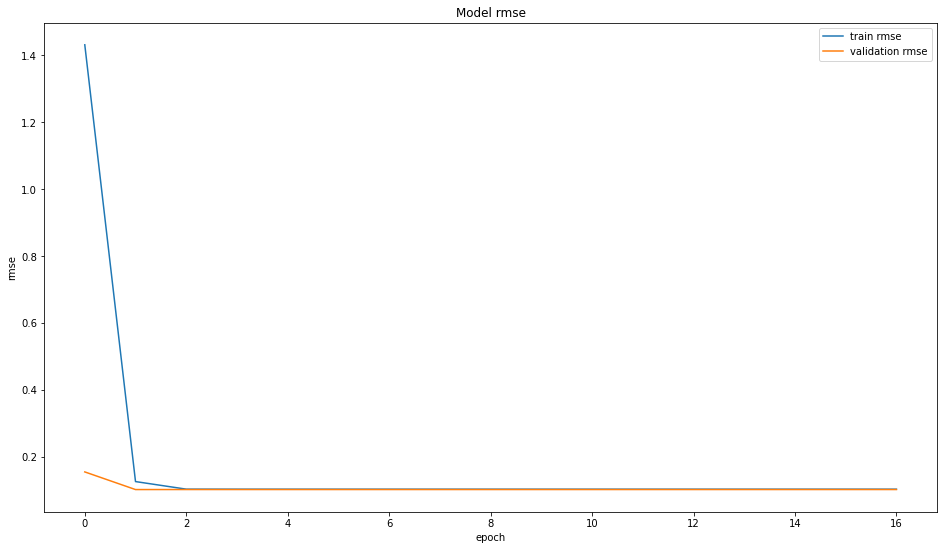

In [26]:
plt.figure(figsize=(16,9))
plt.plot(history.history['rmse'])
plt.plot(history.history['val_rmse'])
plt.title('Model rmse')
plt.ylabel('rmse')
plt.xlabel('epoch')
plt.legend(['train rmse', 'validation rmse'])
plt.show()

In [27]:
pred = lstm_model.predict(x_test)
pred_Inverse = Y_scaler.inverse_transform(pred)
print(pred_Inverse.shape)

(18720, 1)


In [28]:
pred_Inverse

array([[0.36925718],
       [0.36925718],
       [0.36925718],
       ...,
       [0.36925718],
       [0.36925718],
       [0.36925718]], dtype=float32)

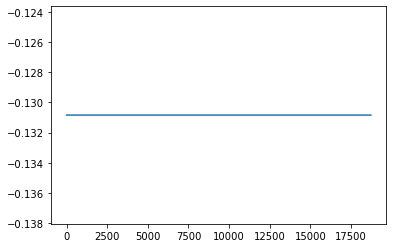

In [20]:
plt.plot(pred_Inverse)

In [144]:
temp = pd.concat([df[test_idx:].reset_index()[['시간']], pd.DataFrame(pred_Inverse)],axis=1)
temp['일자'] = temp['시간'].apply(lambda x: str(x)[:10])

temp['yy'] = temp['일자'].apply(lambda x : x.split('-')[0])
temp['mm'] = temp['일자'].apply(lambda x : x.split('-')[1])
temp['dd'] = temp['일자'].apply(lambda x : x.split('-')[2])

temp.groupby(['yy','mm','dd'])[0].sum().reset_index().rename(columns={0:'heat_supply_day'})
# np.round(temp.groupby(['yy','mm','dd'])[0].sum(),1).reset_index().rename(columns={0:'heat_supply_day'}).to_csv('../result_lstm.csv',index=False)

,yy,mm,dd,heat_supply_day
0,2022,03,04,164.457596
1,2022,03,05,164.470459
2,2022,03,06,164.477280
3,2022,03,07,164.459152
4,2022,03,08,164.460236
5,2022,03,09,164.461105
6,2022,03,10,164.459854
7,2022,03,11,164.458313
8,2022,03,12,164.463013
9,2022,03,13,164.467545


-----------

In [168]:
new_model = tf.keras.models.load_model('LSTM_Multivariate_real.h5')
pred = new_model.predict(x_test)

In [170]:
# pred_Inverse = Y_scaler.inverse_transform(pred)
pred_Inverse = np.expm1(pred)
pred_Inverse

array([[0.3030883],
       [0.3030883],
       [0.3030883],
       ...,
       [0.3030883],
       [0.3030883],
       [0.3030883]], dtype=float32)

In [145]:
temp = pd.concat([df[test_idx:].reset_index()[['시간']], pd.DataFrame(pred_Inverse)],axis=1)
temp['일자'] = temp['시간'].apply(lambda x: x[:10])

temp['yy'] = temp['일자'].apply(lambda x : x.split('-')[0])
temp['mm'] = temp['일자'].apply(lambda x : x.split('-')[1])
temp['dd'] = temp['일자'].apply(lambda x : x.split('-')[2])
temp.groupby(['yy','mm','dd'])[0].sum().reset_index().rename(columns={0:'heat_supply_day'})

,yy,mm,dd,heat_supply_day
0,2022,03,04,432.831635
1,2022,03,05,432.831635
2,2022,03,06,432.831635
3,2022,03,07,432.831635
4,2022,03,08,432.831635
5,2022,03,09,432.831635
6,2022,03,10,432.831635
7,2022,03,11,432.831635
8,2022,03,12,432.831635
9,2022,03,13,432.831635


In [171]:
import matplotlib.pyplot as plt

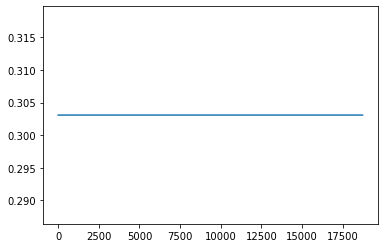

In [172]:
plt.plot(pred_Inverse)